---
title: Change of slope models and Regularization
---

In the last lecture, we started discussing nonlinear regression models. As a motivating example, we considered the following dataset (from FRED) on Annual Estimates of the Resident Population of California (units are thousands of persons) from 1900 to 2024. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

  observation_date   CAPOP
0       1900-01-01  1490.0
1       1901-01-01  1550.0
2       1902-01-01  1623.0
3       1903-01-01  1702.0
4       1904-01-01  1792.0
5       1905-01-01  1893.0
6       1906-01-01  1976.0
7       1907-01-01  2054.0
8       1908-01-01  2161.0
9       1909-01-01  2282.0
    observation_date      CAPOP
115       2015-01-01  38904.296
116       2016-01-01  39149.186
117       2017-01-01  39337.785
118       2018-01-01  39437.463
119       2019-01-01  39437.610
120       2020-01-01  39521.958
121       2021-01-01  39142.565
122       2022-01-01  39142.414
123       2023-01-01  39198.693
124       2024-01-01  39431.263


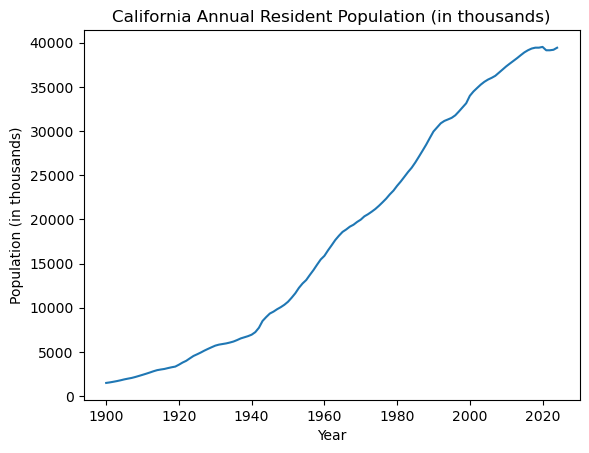

In [2]:
capop = pd.read_csv('CAPOP_11Sept2025.csv')
print(capop.head(10))
print(capop.tail(10))
tme = np.arange(1900, 2025)
plt.plot(tme, capop['CAPOP'], label='California Population')
plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('California Annual Resident Population (in thousands)')
plt.show()

We work with the logarithms of the population data as this will lead to models with better interpretability. 

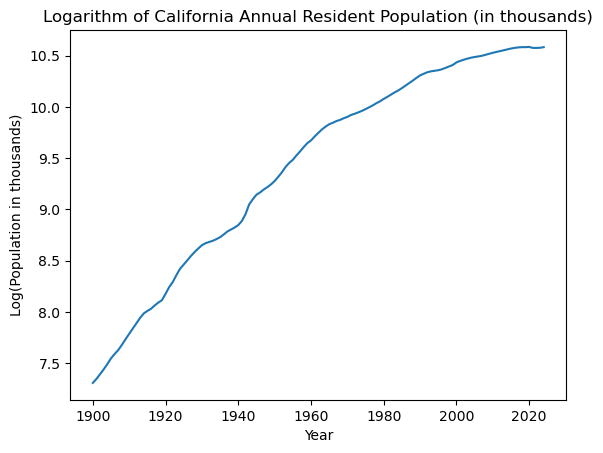

In [3]:
y = np.log(capop['CAPOP'])
n = len(y)
plt.plot(tme, y)
plt.xlabel('Year')
plt.ylabel('Log(Population in thousands)')
plt.title('Logarithm of California Annual Resident Population (in thousands)')
plt.show()

The first model we fit is linear regression: 
\begin{equation*}
   y_t = \beta_0 + \beta_1 t + \epsilon_t 
\end{equation*}
with $\epsilon_t$ being i.i.d $N(0, \sigma^2)$. $\beta_1$ here can be interpreted in terms of the overall growth rate. 

                            OLS Regression Results                            
Dep. Variable:                  CAPOP   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     2343.
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           6.13e-82
Time:                        00:03:03   Log-Likelihood:                 10.482
No. Observations:                 125   AIC:                            -16.96
Df Residuals:                     123   BIC:                            -11.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7301      0.040    191.493      0.0

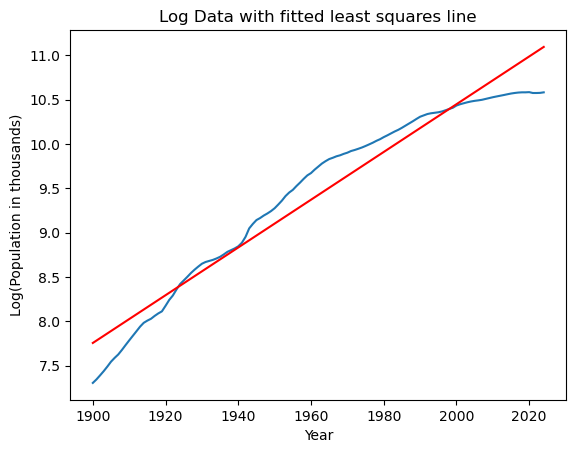

In [4]:
x = np.arange(1, n+1)
X = np.column_stack((np.ones(n), x))
linreg = sm.OLS(y, X).fit()
print(linreg.summary())
plt.plot(tme, y, label='Log(Population in thousands)')
plt.plot(tme, linreg.fittedvalues, color='red', label='Fitted least squares line')
plt.xlabel('Year')
plt.ylabel('Log(Population in thousands)')
plt.title('Log Data with fitted least squares line')
plt.show()

The fitted slope coefficient here is 0.0269. The interpretation is that the population increases by 2.69\% each year. 

### Broken-stick Regression or Change of Slope Model

The simple linear regression model obviously does not provide a good fit to the data. For an improved model, let us consider: 
\begin{equation*}
    y_t = \beta_0 + \beta_1 t + \beta_2 (t - c)_+ + \epsilon_t
\end{equation*}
This model uses $\beta_1$ for the slope before $c$, and $\beta_1 + \beta_2$ for the slope after $c$. We estimated $c$ by the following: 

1. For each fixed value of $c$, calculate RSS
2. Use the value of $c$ with the smallest RSS as the estimate

In [5]:
def rss(c):
    x = np.arange(1, n+1)
    x_c = np.maximum(0, x - c)
    X = np.column_stack((np.ones(n), x, x_c))
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

We compute $RSS(c)$ for each $c$ in a grid of values of $c$ as follows.

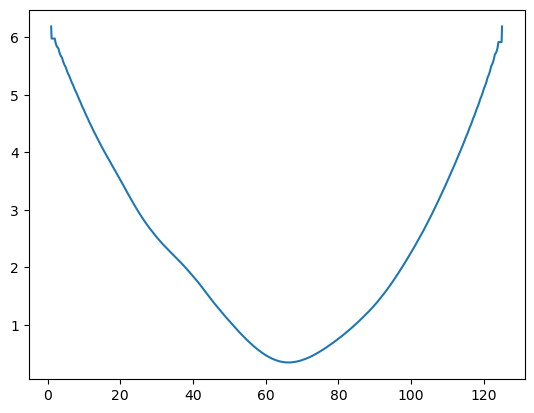

In [6]:
num_c_vals = 1000 #this is the number of different values of c we will try
allcvals = np.linspace(1, n, num_c_vals)
rssvals = np.array([rss(c) for c in allcvals])
plt.plot(allcvals, rssvals)
plt.show()

The estimate $\hat{c}$ is obtained by minimizing $RSS(c)$ as follows. 

In [7]:
c_hat = allcvals[np.argmin(rssvals)]
print(c_hat)
print(c_hat - 1 + tme[0]) #this is the estimated year when the slope changes
rss_smallest = np.min(rssvals)
print(rss_smallest)


66.28928928928929
1965.2892892892892
0.3490460776066189


The fitted values will now look much better than before. 

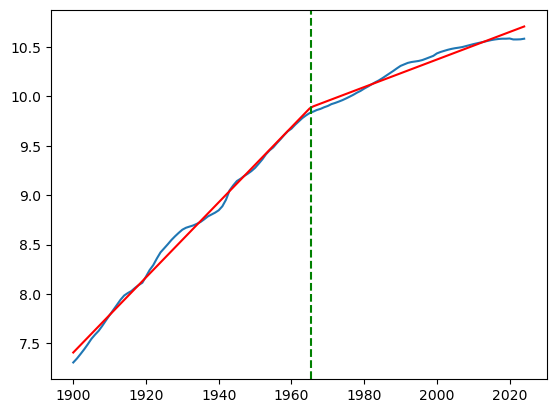

In [8]:
c = c_hat
x = np.arange(1, n+1)
x_c = np.maximum(0, x - c)
X = np.column_stack((np.ones(n), x, x_c))
md = sm.OLS(y, X).fit()
plt.plot(tme, y)
plt.plot(tme, md.fittedvalues, color = 'red')
plt.axvline(c_hat - 1 + tme[0], color='green', linestyle='--')
plt.show()

Point estimates of the other parameters $\beta_0, \beta_1, \beta_2$ are obtained as follows. 

In [9]:
#Estimates of other parameters: 
c = c_hat
x = np.arange(1, n+1)
x_c = np.maximum(0, x - c)
X = np.column_stack((np.ones(n), x, x_c))
md = sm.OLS(y, X).fit()
print(md.params) #this gives estimates of beta_0, beta_1, beta_2 

const    7.369373
x1       0.037996
x2      -0.024062
dtype: float64


The estimate of $\hat{\beta}_1$ is 0.038 and the estimate of $\hat{\beta}_2$ is $-0.024$. This means that the growth rate before 1965 was 3.8\% while the growth rate after 1965 is $3.8 - 2.4 = 1.4$\%. 

### Models with more changes of Slope

We can seek to obtain further improved models by using more points of change of slope. The following model has two points where the slope changes: 
\begin{align*}
   y_t = \beta_0 + \beta_1 t + \beta_2 (t - c_1)_+ + \beta_3 (t - c_2)_+ + \epsilon_t. 
\end{align*}
The unknown parameters now are $\beta_0,\beta_1, \beta_2, \beta_3$ as well as $c_1, c_2$ (also $\sigma$). 

For parameter estimation, we can define the RSS function: 
\begin{align*}
   RSS(c_1, c_2) := \min_{\beta_0, \beta_1, \beta_2, \beta_3} \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 t - \beta_2 (t - c_1)_+ - \beta_3 (t -c_2)_+ \right)^2
\end{align*}
and then we can do some sort of grid optimization for $c_1$ and $c_2$. The code for this is given below.

In [10]:
def rss(c): #c is now a vector of change of slope points
    n = len(y)
    x = np.arange(1, n+1)
    X = np.column_stack((np.ones(n), x))
    if np.isscalar(c):
        c = [c]
    for j in range(len(c)):
        x_c = np.maximum(0, x - c[j])
        X = np.column_stack((X, x_c))
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

In [11]:
num_c_vals = 200 #this is the number of different values of c we will try
c1_gr = np.linspace(1, n, num_c_vals)
c2_gr = np.linspace(1, n, num_c_vals)
C1, C2 = np.meshgrid(c1_gr, c2_gr)
g = pd.DataFrame({'c1': C1.ravel(), 'c2': C2.ravel()})
g['rss'] = g.apply(lambda row: rss([row['c1'], row['c2']]), axis=1)

min_row = g.loc[g['rss'].idxmin()]
print(min_row)
c_opt = min_row[:-1]
rss_opt = min_row.iloc[-1]
print(c_opt - 1 + tme[0]) #these are the estimated years when the slope changes
print(c_hat) #this was the best c in a single change of slope model
print(rss_smallest) #this was the smallest RSS in a single change of slope model
print(rss_opt)

c1      62.065327
c2     101.321608
rss      0.198865
Name: 32298, dtype: float64
c1    1961.065327
c2    2000.321608
Name: 32298, dtype: float64
66.28928928928929
0.3490460776066189
0.19886465005670498


                            OLS Regression Results                            
Dep. Variable:                  CAPOP   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.513e+04
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          6.91e-169
Time:                        00:03:47   Log-Likelihood:                 225.35
No. Observations:                 125   AIC:                            -442.7
Df Residuals:                     121   BIC:                            -431.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3642      0.010    744.549      0.0

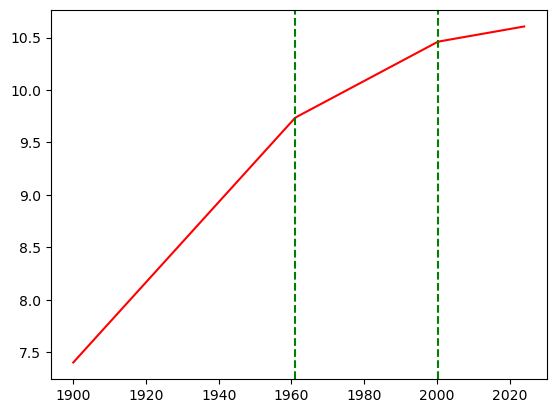

In [12]:
c = np.array(c_opt)
x = np.arange(1, n+1)
x_c1 = np.maximum(0, x - c[0])
x_c2 = np.maximum(0, x - c[1])
X = np.column_stack((np.ones(n), x, x_c1, x_c2))
md_2 = sm.OLS(y, X).fit()
print(md_2.summary())
#plt.plot(tme, y)
#plt.plot(tme, md.fittedvalues, color = 'orange', label='1 change of slope')
plt.plot(tme, md_2.fittedvalues, color = 'red')
plt.axvline(c[0] - 1 + tme[0], color='green', linestyle='--')
plt.axvline(c[1] - 1 + tme[0], color='green', linestyle='--')
plt.show()  

The interpretation of this model is that: before 1961, the growth rate is 3.82\%. Between 1961 and 2000, the growth fell to 3.82 - 1.23 = 2.59\%. After 2000, the growth rate further dropped to 2.59 - 1.98 = 0.61 \%. 

There is a different way of fitting this model that can be computationally more efficient. This involves jointly minimizing least squares over all the parameters. Specifically, we aim to optimize: 
\begin{align*}
   L(\beta_0, \beta_1, \beta_2, \beta_3, c_1, c_2) := \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 t - \beta_2 (t - c_1)_+ - \beta_3 (t - c_2)_+ \right)^2 
\end{align*}
over all the parameters $\beta_0, \beta_1, \beta_2, c_1, c_2$ simultaneously. This optimization is nonlinear and nontrivial but we can use black box optimization libraries. For example, we can use the pytorch library to solve this optimization.

First import the torch libraries. 

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

The following is the code for representing the broken stick regression (or change of slope) model in PyTorch. PyTorch organizes models as classes. 

In [17]:
class BrokenStickRegression(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32))
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))

    def forward(self, x):
        knots_sorted,_ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out = out + self.beta[j+2] * torch.relu(x - knots_sorted[j])
        return out

The class `BrokenStickRegression` inherits from `nn.Module`, which is the base class for all models in PyTorch (linear regression, neural networks, etc.). By subclassing nn.Module, we get access to a lot of PyTorch functionality automatically: for example, it keeps track of parameters, makes them trainable, and allows us to use optimizers like gradient descent.

The term `knots` refers to $c_1, \dots, c_k$. 

In the constructor (`__init__`), the code takes two inputs: a list of initial knot positions (`knots_init`) and initial coefficients (`beta_init`). These are wrapped in `nn.Parameter`, which tells PyTorch: “this is a parameter we want to optimize.” So, during training, PyTorch will update both the regression coefficients and the knot locations.

The `forward` method defines the model equation (how does the model convert input $x$ to output $y$). When you pass in an input x, it:

1. Sorts the knot locations (so they are in order).

2. Starts with the base linear trend, $\beta_0 + \beta_1 x$

3. For each knot, adds a term $\beta_j \text{ReLU}(x - c_j)$

The effect is exactly the broken-stick regression function: linear to start, with slope changes at each knot. The nice thing about using `nn.Module` is that all of this can be trained with PyTorch’s optimization tools.

The raw data here is given by $y$ with covariate $x$ given by time $t = 1, \dots, n$. We do not apply the model to this raw data but we scale the raw data first. The algorithm for parameter fitting will work better with scaled data as opposed to raw data. 

The code below first standardizes the raw input arrays `y_raw` and `x_raw` by subtracting their means and dividing by their standard deviations, resulting in `y_scaled` and `x_scaled`, respectively. This scaling step ensures that both inputs have mean 0 and standard deviation 1, which helps neural network training converge faster and more reliably. After scaling, the arrays are converted into PyTorch tensors (`y_torch` and `x_torch`) with `dtype=torch.float32`, and an additional singleton dimension is added using `unsqueeze(1)` to ensure each data point is treated as a one-dimensional feature vector. Conversion to PyTorch tensors is necessary because PyTorch models and optimization routines (like gradient computation and parameter updates) operate on tensors, not on NumPy arrays.

In [18]:
y_raw = y
x_raw = np.arange(1, n+1)
y_scaled = (y_raw - np.mean(y_raw)) / np.std(y_raw)
x_scaled = (x_raw - np.mean(x_raw)) / np.std(x_raw)
y_torch = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype=torch.float32).unsqueeze(1)

For using PyTorch, the first step is to obtain suitable initial estimates for the parameters. These are deduced as follows. We take $c_1, \dots, c_k$ to be quantiles of the scaled covariate at equal levels. Then we fit the model with $c_1, \dots, c_k$ fixed at these initial values, and obtain the initial values of the coefficients. 

In [19]:
k = 2 #this is the number of knots (changes of slope)
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack((np.ones(n), x_scaled))
for j in range(k):
    x_c = np.maximum(0, x_scaled - knots_init[j])
    X = np.column_stack((X, x_c))
md_init = sm.OLS(y_scaled, X).fit()
beta_init = md_init.params.values
print(knots_init)
print(knots_init * np.std(x_raw) + np.mean(x_raw)) #these are the initial knots in original scale
print(beta_init)

[-0.5727498  0.5727498]
[42.33333333 83.66666667]
[ 0.47153593  1.47880914 -0.44549948 -0.66986532]


The next code line `md_nn = BrokenStickRegression(knots_init=knots_init, beta_init=beta_init)` creates an instance of the custom neural network model `BrokenStickRegression`. It initializes the learnable parameters of the model: the knot locations are set to the values provided in `knots_init`, and the coefficients are set to `beta_init`. This prepares the model for training by defining its initial piecewise linear structure.

In [20]:
md_nn = BrokenStickRegression(knots_init, beta_init)
#This code creates an instance of the BrokenStickRegression class with initial knots and beta values.

The next block of code sets up and runs the training loop for the model `BrokenStickRegression`. The `Adam` optimizer is initialized with the model’s parameters and a learning rate of 0.01, and the loss function is set to mean squared error (`MSELoss`). For 10,000 epochs, the code repeatedly performs one training step: it clears previous gradients with `optimizer.zero_grad()`, computes predictions `y_pred` by passing `x_torch` through the model, evaluates the loss between predictions and true values, backpropagates the loss with `loss.backward()`, and updates the model parameters using `optimizer.step()`. Every 100 epochs, the current epoch and loss value are printed to monitor training progress. Running the code multiple times may be necessary to ensure good convergence, especially because this is a non-convex optimization problem.

In [21]:
optimizer = optim.Adam(md_nn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = md_nn(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.0030975514091551304
Epoch 500, Loss: 0.0016019828617572784
Epoch 1000, Loss: 0.0016019828617572784
Epoch 1500, Loss: 0.0016019828617572784
Epoch 2000, Loss: 0.001605847617611289
Epoch 2500, Loss: 0.0016040573827922344
Epoch 3000, Loss: 0.0016020172042772174
Epoch 3500, Loss: 0.0016019823960959911
Epoch 4000, Loss: 0.0016020506154745817
Epoch 4500, Loss: 0.0016019862378016114
Epoch 5000, Loss: 0.001601983094587922
Epoch 5500, Loss: 0.001601986470632255
Epoch 6000, Loss: 0.0016038458561524749
Epoch 6500, Loss: 0.0016020116163417697
Epoch 7000, Loss: 0.0016099847853183746
Epoch 7500, Loss: 0.001617018016986549
Epoch 8000, Loss: 0.0016035223379731178
Epoch 8500, Loss: 0.001601366326212883
Epoch 9000, Loss: 0.0016012309351935983
Epoch 9500, Loss: 0.001601396594196558


The next code prints out the current loss value, the estimated model coefficients (`beta`), and the estimated knot locations after training. The `detach().numpy()` calls are used to move each tensor from the computation graph to a regular NumPy array so they can be easily printed or further processed without tracking gradients. Finally, it prints `rss_opt`, which represents the smallest residual sum of squares (RSS) achieved with two knots using our previous grid-based search method. This provides a measure of the quality of the PyTorch parameter estimates. 


In [125]:
print(loss.detach().numpy())
print(md_nn.beta.detach().numpy())
print(md_nn.knots.detach().numpy())
print(rss_opt)

0.0016011636
[ 0.34637082  1.3828472  -0.7193925  -0.44183147]
[-0.01797236  1.065274  ]
0.19886465005670517


`rss_opt` seems to be on a different scale to the loss. This is because of the change of scale when we went from `y_raw` and `x_raw` to `y_scaled` and `x_scaled`, as well as because the loss here is Mean-Squared Error (not just Squared Error). We can bring the loss to the same scale as RSS as follows. 

In [23]:
#converting back to original scale
print(loss.detach().numpy() * (np.std(y_raw)**2) * n ) #this rescales the loss to the rss scale
print(md_nn.beta.detach().numpy())
print(md_nn.knots.detach().numpy() * np.std(x_raw) + np.mean(x_raw)) #these are the knots in original scale
print(rss_opt)

0.19868279855727622
[ 0.34637737  1.3828548  -0.7193962  -0.44181848]
[ 62.35171  101.438324]
0.19886465005670498


The loss achieved by PyTorch seems slightly better than the RSS we got from our grid search method. This suggests that PyTorch is working well here. Next let us look at the estimates of $\beta_0, \dots, \beta_{k+1}$ obtained from PyTorch (converted to the original scale). We compare them with the estimates from our previous grid-search method.

In [25]:
#drop intercept
print(md_nn.beta.detach().numpy()[1:] * (np.std(y_raw)/np.std(x_raw)))
print(md_2.params.values[1:])

[ 0.03818281 -0.01986367 -0.01219931]
[ 0.03823489 -0.01978384 -0.01234546]


This is essentially the same model that we found before (in the grid search method, $c_1$ and $c_2$ seem to be swapped though). 

This PyTorch method scales easily to higher values of the number of knots i.e., to fit models of the form: 
\begin{align*}
   y_t = \beta_0 + \beta_1 t + \beta_2 (t - c_1)_+ \beta_3 (t - c_2)_+ + \dots + \beta_{k+1} (t - c_k)_+ + \epsilon_t
\end{align*}
On the other hand, the grid-search method will take very long to run. Below we fit the model with $k = 3$. 

In [26]:
k = 3 #this is the number of knots (changes of slope)
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack((np.ones(n), x_scaled))
for j in range(k):
    x_c = np.maximum(0, x_scaled - knots_init[j])
    X = np.column_stack((X, x_c))
md_init = sm.OLS(y_scaled, X).fit()
beta_init = md_init.params.values
print(knots_init)
print(knots_init * np.std(x_raw) + np.mean(x_raw)) #these are the initial knots in original scale
print(beta_init)

[-0.85912469  0.          0.85912469]
[32. 63. 94.]
[ 0.50608904  1.50671232 -0.2370822  -0.53040235 -0.42440376]


In [27]:
md_nn_k = BrokenStickRegression(knots_init, beta_init)
#This code creates an instance of the BrokenStickRegression class with initial knots and beta values.

In [28]:
optimizer = optim.Adam(md_nn_k.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = md_nn_k(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.0011482465779408813
Epoch 500, Loss: 0.0008120193961076438
Epoch 1000, Loss: 0.0008117101388052106
Epoch 1500, Loss: 0.0008117101970128715
Epoch 2000, Loss: 0.0008117840625345707
Epoch 2500, Loss: 0.0008117103716358542
Epoch 3000, Loss: 0.0008117103716358542
Epoch 3500, Loss: 0.0008117651450447738
Epoch 4000, Loss: 0.0008117102552205324
Epoch 4500, Loss: 0.0008117100223898888
Epoch 5000, Loss: 0.0008117099059745669
Epoch 5500, Loss: 0.0008117102552205324
Epoch 6000, Loss: 0.0008117340039461851
Epoch 6500, Loss: 0.0008117101388052106
Epoch 7000, Loss: 0.0008117136894725263
Epoch 7500, Loss: 0.0008117101388052106
Epoch 8000, Loss: 0.0008117130491882563
Epoch 8500, Loss: 0.0008117096731439233
Epoch 9000, Loss: 0.0008117114193737507
Epoch 9500, Loss: 0.0008117103134281933


The estimates of the knots are given below. 

In [29]:
c_est = md_nn_k.knots.detach().numpy() * np.std(x_raw) + np.mean(x_raw)
print(c_est)

[ 24.850475  65.16884  100.91917 ]


The rss value and the fitted values are computed as below. 

In [31]:
c = c_est
x = np.arange(1, n+1)
X = np.column_stack((np.ones(n), x))
if np.isscalar(c):
    c = [c]
for j in range(len(c)):
    x_c = np.maximum(0, x - c[j])
    X = np.column_stack((X, x_c))
md_k = sm.OLS(y, X).fit() 
rss_k = np.sum(md_k.resid ** 2)
print(rss_k)

0.10071745300736597


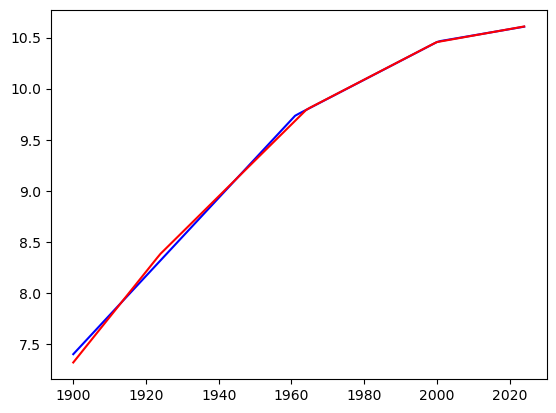

In [33]:
#plt.plot(tme, y, color= 'black')
plt.plot(tme, md_2.fittedvalues, color = 'blue', label='2 changes of slope')
plt.plot(tme, md_k.fittedvalues, color = 'red', label = 'k changes of slope')
#plt.axvline(c[0] - 1 + tme[0], color='green', linestyle='--')
#plt.axvline(c[1] - 1 + tme[0], color='green', linestyle='--')
plt.show()  

The fitted values from the $k = 3$ model seem to be quite close to the fitted values for the $k = 2$ model. Go back and run the method for $k = 6$. This should lead to overfitting and the fitted values will look a lot like the data. 

## High-dimensional Linear Regression and Regularization

We now consider the model:
\begin{equation*}
  y_t = \beta_0 + \beta_1 (t - 1) + \beta_2 (t - 2)_+ + \beta_3 (t - 3)_+ + \dots + \beta_{n-1} (t - (n-1))_+ + \epsilon_t
\end{equation*}
We can write this as
\begin{equation*}
   y = X_{\text{full}} \beta + \epsilon
\end{equation*}
where $X_{\text{full}}$ is constructed as below. 

In [144]:
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 122. 121. ...   1.   0.  -0.]
 [  1. 123. 122. ...   2.   1.   0.]
 [  1. 124. 123. ...   3.   2.   1.]]


If we fit this model without any regularization, we get the following. 

In [145]:
mdfull = sm.OLS(y, Xfull).fit()
print(mdfull.summary())

                            OLS Regression Results                            
Dep. Variable:                  CAPOP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 30 Sep 2025   Prob (F-statistic):                nan
Time:                        16:51:38   Log-Likelihood:                 3409.6
No. Observations:                 125   AIC:                            -6569.
Df Residuals:                       0   BIC:                            -6216.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3065        inf          0        n

/Users/aditya/mambaforge/envs/stat153fall2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/aditya/mambaforge/envs/stat153fall2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/aditya/mambaforge/envs/stat153fall2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In this unregularized estimation, the estimate of $\beta_0$ equals $y_1$, the estimate of $\beta_1$ is $y_2 - y_1$, and the estimate of $\beta_j$ is $y_{j+1} - 2 y_j + y_{j-1}$ for $j = 2, \dots, n-1$. Let us check this. 

In [147]:
print(y[0])
print(y[1] - y[0])
print(y[2] - y[1] - y[1] + y[0])

7.306531398939505
0.03947881097378758
0.006542546627510859


We shall study regularization in the next lecture.